In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [22]:
df_count = pd.read_csv("results/mobilenet/mnist_count.csv")
df_count

,execution,epoch,train_loss,val_loss,val_acc,time,zero_relu_call,total_relu_call
0,1,1,0.845916,0.476770,0.830500,88.814496,54,1155840000
1,1,2,0.451740,0.405229,0.852611,88.324428,42,1155840000
2,1,3,0.391541,0.392318,0.860444,88.185514,59,1155840000
3,1,4,0.354499,0.372190,0.867944,86.346142,39,1155840000
4,1,5,0.326716,0.365201,0.866333,84.088821,41,1155840000
...,...,...,...,...,...,...,...,...
150,5,27,0.137550,0.356258,0.887111,107.036461,80,1155840000
151,5,28,0.136617,0.368378,0.884389,106.969211,51,1155840000
152,5,29,0.132635,0.377365,0.881056,106.204812,40,1155840000
153,5,30,0.133609,0.370235,0.886111,106.019657,63,1155840000


In [23]:
df_original = pd.read_csv("results/mobilenet/mnist_original.csv")
df_original

,execution,epoch,train_loss,val_loss,val_acc,time,zero_relu_call,total_relu_call
0,1,1,0.836612,0.474861,0.833056,58.032173,0,0
1,1,2,0.446887,0.428650,0.835556,58.177491,0,0
2,1,3,0.386569,0.377040,0.864944,57.229786,0,0
3,1,4,0.347110,0.354134,0.872000,56.822654,0,0
4,1,5,0.322438,0.338555,0.874778,57.114319,0,0
...,...,...,...,...,...,...,...,...
150,5,27,0.146136,0.343909,0.887000,68.102281,0,0
151,5,28,0.142286,0.359889,0.885167,67.918822,0,0
152,5,29,0.135884,0.367885,0.880056,68.070508,0,0
153,5,30,0.135213,0.357095,0.886611,67.912628,0,0


In [24]:
df_diff = pd.read_csv("results/mobilenet/mnist_diff.csv")
df_diff

,execution,epoch,train_loss,val_loss,val_acc,time,zero_relu_call,total_relu_call
0,1,1,0.824481,0.456749,0.842333,56.634748,0,0
1,1,2,0.437628,0.429860,0.842389,56.636864,0,0
2,1,3,0.377163,0.383522,0.859778,56.881165,0,0
3,1,4,0.341331,0.364404,0.867722,56.386786,0,0
4,1,5,0.313462,0.349479,0.871500,56.676396,0,0
...,...,...,...,...,...,...,...,...
150,5,27,0.131132,0.367549,0.887333,52.718695,0,0
151,5,28,0.133876,0.364218,0.884389,56.425597,0,0
152,5,29,0.124871,0.391035,0.881278,56.528672,0,0
153,5,30,0.124163,0.365014,0.888056,56.673715,0,0


In [25]:
# splitting training and test
df_count_train = df_count[df_count["epoch"] != -1]
df_count_test = df_count[df_count["epoch"] == -1]
df_original_train = df_original[df_original["epoch"] != -1]
df_original_test = df_original[df_original["epoch"] == -1]
df_diff_train = df_diff[df_diff["epoch"] != -1]
df_diff_test = df_diff[df_diff["epoch"] == -1]

In [26]:
# add relu proportion
df_count_train["relu_proportion"] = df_count_train["zero_relu_call"] / df_count_train["total_relu_call"]
df_original_train["relu_proportion"] = df_original_train["zero_relu_call"] / df_original_train["total_relu_call"]
df_diff_train["relu_proportion"] = df_diff_train["zero_relu_call"] / df_diff_train["total_relu_call"]

/tmp/ipykernel_9004/561248041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_count_train["relu_proportion"] = df_count_train["zero_relu_call"] / df_count_train["total_relu_call"]
/tmp/ipykernel_9004/561248041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_original_train["relu_proportion"] = df_original_train["zero_relu_call"] / df_original_train["total_relu_call"]
/tmp/ipykernel_9004/561248041.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

## Frequência da ReLU

Tamanho da rede: 1_528_106

In [27]:
temp = df_count_train.groupby("execution").sum()
relu_proportion = temp["zero_relu_call"] / temp["total_relu_call"]
print(f"Proporção Média da ReLU: {relu_proportion.mean()}    1/{round(1/relu_proportion.mean()):_}")

Proporção Média da ReLU: 4.531192321889997e-08    1/22_069_246


<Axes: xlabel='epoch', ylabel='relu_proportion'>

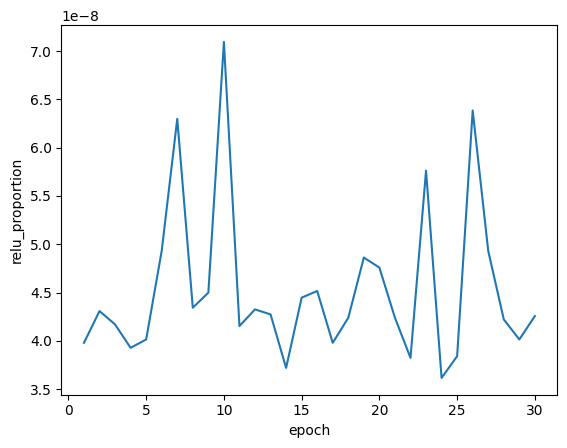

In [28]:
df_train_avg = df_count_train.groupby("epoch").mean()
sns.lineplot(data=df_train_avg, x="epoch", y="relu_proportion")

## Eficiência do Modelo

In [29]:
print(f"Acurácia (teste) média: {round(100*df_count_test['val_acc'].mean(), 2)}%")

Acurácia (teste) média: 88.12%


<Axes: xlabel='epoch', ylabel='train_loss'>

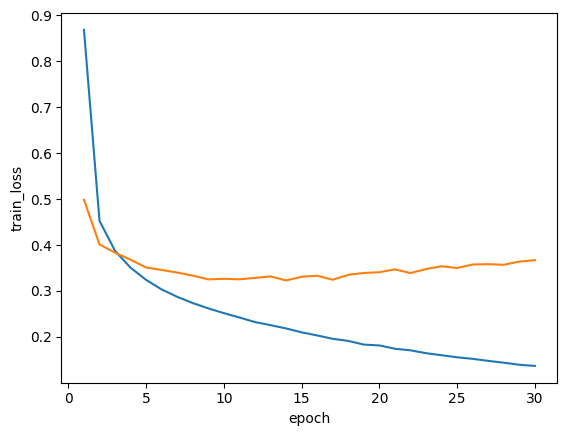

In [30]:
sns.lineplot(data=df_train_avg, x="epoch", y="train_loss")
sns.lineplot(data=df_train_avg, x="epoch", y="val_loss")

In [31]:
df_train_sum = df_count_train.groupby("execution").sum()
seconds_avg = round(df_train_sum["time"].mean())
minutes_avg = seconds_avg // 60
seconds_avg = seconds_avg % 60
print(f"Tempo médio de treino: {minutes_avg}:{seconds_avg}")

Tempo médio de treino: 45:32


## Comparando com funções diferenciáveis

In [32]:
df_train_avg_diff = df_diff_train.groupby("epoch").mean()
df_train_avg_original = df_original_train.groupby("epoch").mean()

Text(0.5, 1.0, 'Tempo por Epoca')

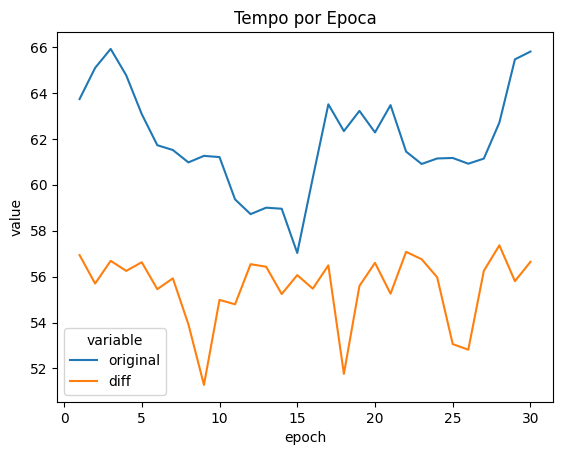

In [33]:
temp = pd.DataFrame()
temp["original"] = df_train_avg_original["time"]
temp["diff"] = df_train_avg_diff["time"]
temp["epoch"] = df_train_avg.index
temp = pd.melt(temp, ["epoch"])
ax = sns.lineplot(data=temp, x="epoch", y="value", hue="variable")
ax.set_title("Tempo por Epoca")

In [34]:
# tempo total de treino
time_original = round(df_train_avg_original["time"].sum())
time_diff = round(df_train_avg_diff["time"].sum())

print(f"Tempo total de treino (não diff): {time_original//60:02}:{time_original%60:02}")
print(f"Tempo total de treino (diff): {time_diff//60:02}:{time_diff%60:02}")
print(f"Diferença: {round(100*(time_diff - time_original) / time_original, 2)}%")

Tempo total de treino (não diff): 30:58
Tempo total de treino (diff): 27:46
Diferença: -10.33%


Text(0.5, 1.0, 'Loss (Treino) por Epoca')

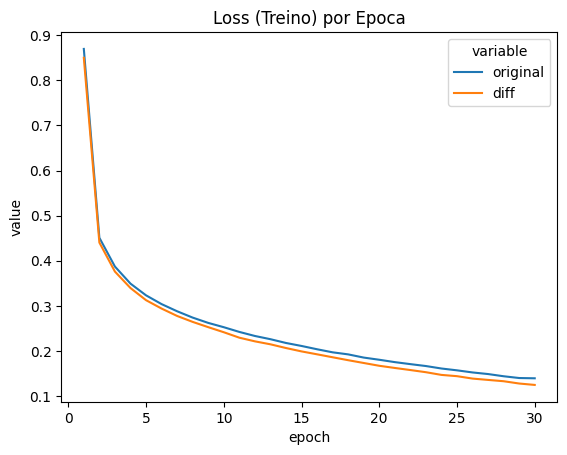

In [35]:
temp = pd.DataFrame()
temp["original"] = df_train_avg_original["train_loss"]
temp["diff"] = df_train_avg_diff["train_loss"]
temp["epoch"] = df_train_avg.index
temp = pd.melt(temp, ["epoch"])
ax = sns.lineplot(data=temp, x="epoch", y="value", hue="variable")
ax.set_title("Loss (Treino) por Epoca")

Text(0.5, 1.0, 'Loss (Validacao) por Epoca')

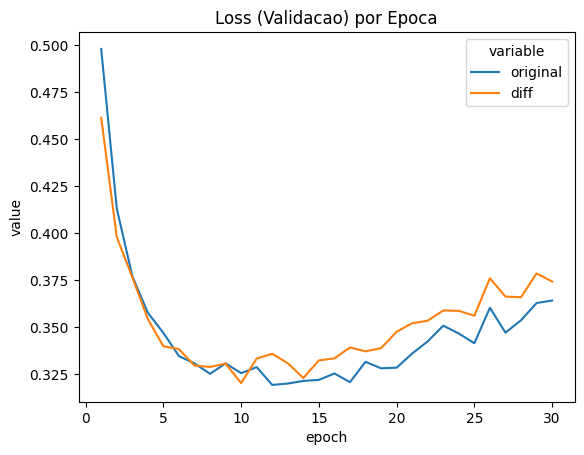

In [36]:
temp = pd.DataFrame()
temp["original"] = df_train_avg_original["val_loss"]
temp["diff"] = df_train_avg_diff["val_loss"]
temp["epoch"] = df_train_avg.index
temp = pd.melt(temp, ["epoch"])
ax = sns.lineplot(data=temp, x="epoch", y="value", hue="variable")
ax.set_title("Loss (Validacao) por Epoca")

Text(0.5, 1.0, 'Acurácia (Validacao) por Epoca')

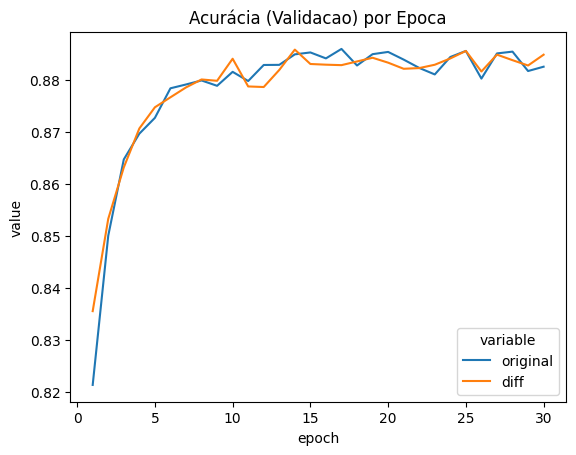

In [37]:
temp = pd.DataFrame()
temp["original"] = df_train_avg_original["val_acc"]
temp["diff"] = df_train_avg_diff["val_acc"]
temp["epoch"] = df_train_avg.index
temp = pd.melt(temp, ["epoch"])
ax = sns.lineplot(data=temp, x="epoch", y="value", hue="variable")
ax.set_title("Acurácia (Validacao) por Epoca")

In [38]:
# melhor época original
best_original = df_train_avg_original[df_train_avg_original["val_loss"] == df_train_avg_original["val_loss"].min()]
best_original

,execution,train_loss,val_loss,val_acc,time,zero_relu_call,total_relu_call,relu_proportion
epoch,,,,,,,,
12,3.0,0.233306,0.319299,0.882867,58.719675,0.0,0.0,NaN


In [39]:
# melhor época diff
best_diff = df_train_avg_diff[df_train_avg_diff["val_loss"] == df_train_avg_diff["val_loss"].min()]
best_diff

,execution,train_loss,val_loss,val_acc,time,zero_relu_call,total_relu_call,relu_proportion
epoch,,,,,,,,
10,3.0,0.241601,0.320295,0.884067,54.986208,0.0,0.0,NaN


In [40]:
column_original = np.array([best_original.index[0]] + list(best_original.values[0]))[:6]
column_diff = np.array([best_diff.index[0]] + list(best_diff.values[0]))[:6]
column_difference = 100 * (column_diff - column_original) / column_original
indexes = ["epoch"] + list(best_original)[:5]
pd.DataFrame({"Não Diferenciáveis": column_original, "Diferenciáveis": column_diff, "Diferença (%)": column_difference}, index=indexes)

,Não Diferenciáveis,Diferenciáveis,Diferença (%)
epoch,12.000000,10.000000,-16.666667
execution,3.000000,3.000000,0.000000
train_loss,0.233306,0.241601,3.555475
val_loss,0.319299,0.320295,0.311926
val_acc,0.882867,0.884067,0.135921
time,58.719675,54.986208,-6.358119


In [41]:
# tempo para chegar na melhor época
epoch_original = df_train_avg_original[df_train_avg_original["val_loss"] == df_train_avg_original["val_loss"].min()].index[0]
epoch_diff = df_train_avg_diff[df_train_avg_diff["val_loss"] == df_train_avg_diff["val_loss"].min()].index[0]

time_original = round(df_train_avg_original.head(epoch_original)["time"].sum())
time_diff = round(df_train_avg_diff.head(epoch_diff)["time"].sum())

print(f"Tempo de treino até melhor época (não diff): {time_original//60:02}:{time_original%60:02}")
print(f"Tempo de treino até melhor época (diff): {time_diff//60:02}:{time_diff%60:02}")
print(f"Diferença: {round(100*(time_diff - time_original) / time_original, 2)}%")

Tempo de treino até melhor época (não diff): 12:27
Tempo de treino até melhor época (diff): 09:14
Diferença: -25.84%


## Avaliação nos dados de teste

In [42]:
df_diff_test

,execution,epoch,train_loss,val_loss,val_acc,time,zero_relu_call,total_relu_call
30,1,-1,NaN,0.409626,0.8763,1.985484,0,0
61,2,-1,NaN,0.391504,0.8874,2.101640,0,0
92,3,-1,NaN,0.387158,0.8851,2.058947,0,0
123,4,-1,NaN,0.420590,0.8743,2.104831,0,0
154,5,-1,NaN,0.400472,0.8802,2.024286,0,0


In [43]:
df_original_test

,execution,epoch,train_loss,val_loss,val_acc,time,zero_relu_call,total_relu_call
30,1,-1,NaN,0.379616,0.8779,1.770334,0,0
61,2,-1,NaN,0.391828,0.8801,1.766327,0,0
92,3,-1,NaN,0.395823,0.8772,1.781220,0,0
123,4,-1,NaN,0.372006,0.8800,1.775836,0,0
154,5,-1,NaN,0.381279,0.8781,1.793418,0,0


In [44]:
# prediction time
diff_time = df_diff_test["time"].mean()
original_time = df_original_test["time"].mean()
diff = (diff_time - original_time) / original_time
print(f"Tempo Diferenciáveis: {diff_time} seg")
print(f"Tempo Não-diferenciáveis: {original_time} seg")
print(f"Diferenciáveis são {round(100*diff, 2)}% mais lentas")

Tempo Diferenciáveis: 2.0550375461578367 seg
Tempo Não-diferenciáveis: 1.7774271965026855 seg
Diferenciáveis são 15.62% mais lentas


In [45]:
# loss
diff_loss = df_diff_test["val_loss"].mean()
original_loss = df_original_test["val_loss"].mean()
diff = (diff_loss - original_loss) / original_loss
print(f"Loss Diferenciáveis: {diff_loss}")
print(f"Loss Não-diferenciáveis: {original_loss}")
print(f"Diferenciáveis são {round(100*diff, 2)}% piores")

Loss Diferenciáveis: 0.40187012314796444
Loss Não-diferenciáveis: 0.384110409617424
Diferenciáveis são 4.62% piores


In [46]:
# acc
diff_acc = df_diff_test["val_acc"].mean()
original_acc = df_original_test["val_acc"].mean()
diff = (diff_acc - original_acc) / original_acc
print(f"Acurácia Diferenciáveis: {diff_acc} seg")
print(f"Acurácia Não-diferenciáveis: {original_acc} seg")
if diff < 0:
    print(f"Acurácia das diferenciáveis é {-round(100*diff, 2)}% menor")
else:
    print(f"Acurácia das diferenciáveis é {round(100*diff, 2)}% maior")

Acurácia Diferenciáveis: 0.88066 seg
Acurácia Não-diferenciáveis: 0.87866 seg
Acurácia das diferenciáveis é 0.23% maior
